# Milestone 2 Predicting heart disease
## Goal: Create an FFN can predict heart disease given the data

In [359]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from time import perf_counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_18744\1239200458.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import the data

In [360]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

# Clean and normalize the data

In [361]:
# Remove a single "?" and make sure the columns are floats
data = data.replace("?", np.nan).dropna()
data.ca = data.ca.astype(float)
data.thal = data.thal.astype(float)

# Normalize the data
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex', 'fbs', 'exang', 'DISEASE'])
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Create function to get the dataloaders

In [362]:
def get_dataloaders(data):

    # Binarize the disease data
    data.DISEASE = (data.DISEASE > 0).astype(int)

    print(f"Data balance: {data.DISEASE.sum() / len(data.DISEASE)}")

    # convert from pandas dataframe to tensor
    dataT  = torch.tensor( data[data.keys().drop("DISEASE")].values ).float()

    # transform to N-1 column matrix for PyTorch
    labels = torch.tensor( np.vstack(data.DISEASE.values) ).float()

    # use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=50)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)

    # finally, translate into dataloader objects
    batchsize    = 8
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader

In [363]:
train_loader, test_loader = get_dataloaders(data)
print(next(iter(train_loader))[0].size())
print(next(iter(train_loader))[1].size())

print(next(iter(test_loader))[0].size())
print(next(iter(test_loader))[1].size())

Data balance: 0.4612794612794613
torch.Size([8, 13])
torch.Size([8, 1])
torch.Size([50, 13])
torch.Size([50, 1])


# Create function to get the NN, loss function and optimizer

In [364]:
class HeartDiseaseANN(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(13,16)

        ### hidden layer 1
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16,16)

        # self.bnorm2 = nn.BatchNorm1d(16)
        # self.fc2 = nn.Linear(16,16)

        ### output layer
        self.output = nn.Linear(16,1)

    # forward pass
    def forward(self,x):

        x = F.relu6(self.input(x))

        # Normalize, weights, activate
        x = F.relu6(self.fc1( self.bnorm1(x) ))
        # x = F.relu6(self.fc2( self.bnorm2(x) ))
        # x = F.relu(self.fc3( self.bnorm3(x) ))

        # No sigmoid on output -> in loss function
        return self.output(x)

In [365]:
# create a class for the model
def createTheNet():

    net = HeartDiseaseANN()

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

    return net,lossfun,optimizer

# Test the network

In [366]:
# No errors when passing random data through it?
# net, lossfun, optimzer = createTheNet()
# randomData = torch.randn((1, 13))
# net(randomData)

# Create function to train the model

In [367]:
# a function that trains the model

# global parameter
numepochs = 100

def trainTheModel(train_loader, test_loader, net, lossfun, optimzer):
    start_time = perf_counter()

    # initialize losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        net.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            predictions = (torch.sigmoid(yHat)>.5).float()
            batchAcc.append( 100*torch.mean((predictions==y).float()) )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
        predictions = (torch.sigmoid(yHat)>.5).float()
        testAcc.append( 100*torch.mean((predictions==y).float()) )

    end_time = perf_counter()
    print(f"Training took {end_time - start_time:.2f}s.")

    # function output
    return trainAcc,testAcc,losses

In [368]:
train_loader, test_loader = get_dataloaders(data)
net, lossfun, optimzer = createTheNet()
trainAcc,testAcc,losses = trainTheModel(train_loader, test_loader, net, lossfun, optimzer)

Data balance: 0.4612794612794613
Training took 3.67s.


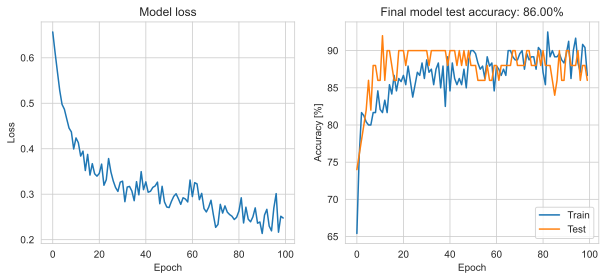

In [369]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Model loss")

plt.subplot(122)
plt.plot(trainAcc, label="Train")
plt.plot(testAcc, label="Test")
plt.legend()
plt.ylabel("Accuracy [%]")
plt.xlabel("Epoch")
plt.title(f"Final model test accuracy: {testAcc[-1]:.2f}%")

plt.show()

In [370]:
# for _ in range(20):
#     net, lossfun, optimzer = createTheNet()
#     _,testAcc,_ = trainTheModel(train_loader, test_loader, net, lossfun, optimzer)
#     print(f"Final model test accuracy: {testAcc[-1]}%")